# GSE172511
## Xiaonan Wang
## 18Aug2022

In [3]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.7.1 anndata==0.7.8 umap==0.5.1 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6


# Data in

In [1]:
FileDir = '/nfs01data1/Groups/Wangxiaonan/share/rev_MI/GSE172511/'

In [28]:
Files = [x for x in listdir(FileDir) if 'GSM' in x]
print(Files)
PreF = np.unique([re.findall('(.*_.*_.*)_.*',x)[0] for x in Files])
print(PreF)
print(len(PreF))

['GSM5258245_uninjured_heart_barcodes.tsv', 'GSM5258245_uninjured_heart_genes.tsv', 'GSM5258245_uninjured_heart_matrix.mtx', 'GSM5258246_regenerating_heart_barcodes.tsv', 'GSM5258246_regenerating_heart_genes.tsv', 'GSM5258246_regenerating_heart_matrix.mtx']
['GSM5258245_uninjured_heart' 'GSM5258246_regenerating_heart']
2


In [4]:
# sorted GFP+ tcf21 epicardial cells
meta = pd.DataFrame([['GSM5258245', '4-10m', 'adult', 'Healthy', '7', 'tcf21:nucEGFP:Z-CAT', 'heart', 'GSE172511', 'Epicardial cells', 'WT', 'Danio rerio', 'mixed', 'Sun'],
                   ['GSM5258246', '4-10m', 'adult', 'Injured', '7', 'tcf21:nucEGFP:Z-CAT', 'heart', 'GSE172511', 'Epicardial cells', 'WT', 'Danio rerio', 'mixed', 'Sun']
                    ], columns = ['Index', 'Age', 'Development_stage', 'Condition', 'Day', 'Strain', 'Tissue', 'StudyID', 'CellType', 'Genotype', 'Organism', 'Gender', 'Author'])

In [34]:
adata = []
for idx, row in meta.iterrows():
    FN = [x for x in PreF if row['Index'] in x][0]
    print(FN)
    FN = FN + '_'
    adata_sub = sc.read_10x_mtx(FileDir, prefix=FN, cache=True)
    adata_sub.obs['Index'] = row['Index']
    adata_sub.obs['Age'] = row['Age']
    adata_sub.obs['Development_stage'] = row['Development_stage']
    adata_sub.obs['Condition'] = row['Condition']
    adata_sub.obs['Day'] = row['Day']
    adata_sub.obs['Strain'] = row['Strain']
    adata_sub.obs['Tissue'] = row['Tissue']
    adata_sub.obs['StudyID'] = row['StudyID']
    adata_sub.obs['CellType'] = row['CellType']
    adata_sub.obs['Genotype'] = row['Genotype']
    adata_sub.obs['Organism'] = row['Organism']
    adata_sub.obs['Gender'] = row['Gender']
    adata_sub.obs['Author'] = row['Author']
    if 'EGFP' in adata_sub.var_names:
        adata_sub.obs['EGFP'] = adata_sub[:,'EGFP'].X.toarray().flatten()
        adata_sub = adata_sub[:, ~np.in1d(adata_sub.var_names, 'EGFP')].copy()
    adata_sub.var_names_make_unique()
    adata.append(adata_sub)
    del adata_sub

GSM5258245_uninjured_heart


... writing an h5ad cache file to speedup reading next time


GSM5258246_regenerating_heart


... writing an h5ad cache file to speedup reading next time


In [36]:
adata

[AnnData object with n_obs × n_vars = 4250 × 32058
     obs: 'Index', 'Age', 'Development_stage', 'Condition', 'Day', 'Strain', 'Tissue', 'StudyID', 'CellType', 'Genotype', 'Organism', 'Gender', 'Author', 'EGFP'
     var: 'gene_ids',
 AnnData object with n_obs × n_vars = 4947 × 32057
     obs: 'Index', 'Age', 'Development_stage', 'Condition', 'Day', 'Strain', 'Tissue', 'StudyID', 'CellType', 'Genotype', 'Organism', 'Gender', 'Author', 'EGFP'
     var: 'gene_ids']

# QC

In [37]:
[x for x in adata[0].var_names if x.startswith('mt-')]

['mt-nd1',
 'mt-nd2',
 'mt-co1',
 'mt-co2',
 'mt-atp8',
 'mt-atp6',
 'mt-co3',
 'mt-nd3',
 'mt-nd4l',
 'mt-nd4',
 'mt-nd5',
 'mt-nd6',
 'mt-cyb']

In [38]:
for i in range(len(adata)):
    adata[i].var['mt'] = adata[i].var_names.str.startswith('mt-') 
    sc.pp.calculate_qc_metrics(adata[i], qc_vars=['mt'], inplace=True)

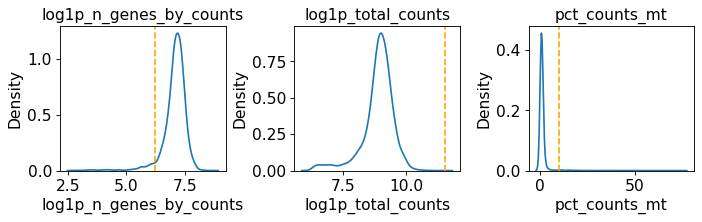

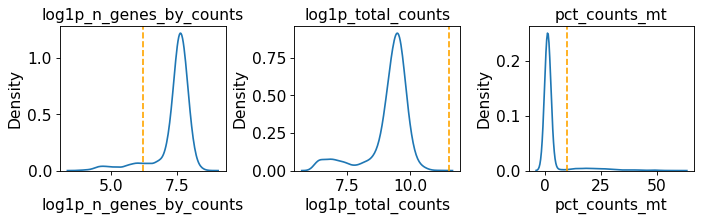

In [44]:
cutoffs = [[500,100000, np.exp(10)],
           [500,100000, np.exp(10)]
           ]
for i in range(len(adata)):
    obs_terms = ['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt']
    fig,ax = plt.subplots(1,3, figsize=(9,3))
    for j in range(len(obs_terms)):
        sns.kdeplot(adata[i].obs[obs_terms[j]], ax=ax[j])
        ax[j].grid(False)
        ax[j].set_title(obs_terms[j])
        ax[j].axvline(np.log1p(cutoffs[i][j]), c='orange', linestyle='--')
    plt.tight_layout()

In [45]:
for i in range(len(adata)):
    sc.pp.filter_cells(adata[i], min_genes=cutoffs[i][0])
    #sc.pp.filter_genes(adata[i], min_cells=1)
    adata[i] = adata[i][(adata[i].obs['total_counts'] <= cutoffs[i][1]) & (adata[i].obs['pct_counts_mt'] <= np.log(cutoffs[i][2])), :].copy()
    print(adata[i].obs['Condition'].value_counts().sort_index())

filtered out 195 cells that have less than 500 genes expressed
filtered out 423 cells that have less than 500 genes expressed


Healthy    4044
Name: Condition, dtype: int64
Injured    4456
Name: Condition, dtype: int64


In [46]:
for i in range(len(adata)):
    print(adata[i].shape)

(4044, 32058)
(4456, 32057)


In [47]:
#combine and save the raw counts
adata1 = anndata.AnnData.concatenate(*adata) #, join='outer', fill_value=0

In [48]:
adata1.shape

(8500, 32057)

In [49]:
sc.pp.filter_genes(adata1, min_cells=1)

filtered out 9137 genes that are detected in less than 1 cells


In [51]:
adata1.write('./write/GSE172511_raw.h5ad')

# Normalisation

In [52]:
adata = sc.read('./write/GSE172511_raw.h5ad')

In [53]:
print(adata.shape)

(8500, 22920)


In [54]:
# normalisation
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [55]:
# log counts
sc.pp.log1p(adata)

In [56]:
adata.raw = adata

In [57]:
print(adata.shape)

(8500, 22920)


In [58]:
adata.write('./write/GSE172511_lognorm.h5ad')

# Cell Cycle Assignment

In [59]:
adata = sc.read('./write/GSE172511_lognorm.h5ad')

In [60]:
print(adata.shape)

(8500, 22920)


In [61]:
cell_cycle_genes = [x.strip()[0].upper()+x.strip()[1:].lower() for x in open('/nfs01data1/Groups/Wangxiaonan/Lab_members/Files/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

97


In [62]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
print(len(s_genes))
print(len(g2m_genes))

43
54


In [64]:
GN = pd.read_csv('../drerio_mmusculus.txt', delimiter='\t', index_col=0)

In [67]:
GN.head(3)

,external_gene_name,mmusculus_homolog_ensembl_gene,mmusculus_homolog_associated_gene_name
ensembl_gene_id,,,
ENSDARG00000063344,fam162a,ENSMUSG00000019909,Fam162b
ENSDARG00000097685,si:ch211-235i11.3,NaN,NaN
ENSDARG00000036008,caly,ENSMUSG00000025468,Caly


In [66]:
SGo = np.intersect1d(s_genes, [str(x) for x in GN['mmusculus_homolog_associated_gene_name']])
Stab = GN[np.in1d([str(x) for x in GN['mmusculus_homolog_associated_gene_name']], SGo)]
G2Mo = np.intersect1d(g2m_genes, [str(x) for x in GN['mmusculus_homolog_associated_gene_name']])
G2Mtab = GN[np.in1d([str(x) for x in GN['mmusculus_homolog_associated_gene_name']], G2Mo)]

In [68]:
sg_drerio = np.unique([str(x) for x in Stab['external_gene_name']])
g2mg_drerio = np.unique([str(x) for x in G2Mtab['external_gene_name']])
print(len(sg_drerio))
print(len(g2mg_drerio))

40
51


In [69]:
sg_drerio_ol = np.intersect1d(sg_drerio, adata.raw.var_names)
g2mg_drerio_ol = np.intersect1d(g2mg_drerio, adata.raw.var_names)
print(len(sg_drerio_ol))
print(len(g2mg_drerio_ol))

39
48


In [70]:
Index = adata.obs['Index'].cat.categories
print(Index)

Index(['GSM5258245', 'GSM5258246'], dtype='object')


In [71]:
phase = []
for i in range(len(Index)):
    adata_sub = adata[adata.obs['Index'] == Index[i]].copy()
    print(adata_sub.shape)
    sc.pp.scale(adata_sub)
    sc.tl.score_genes_cell_cycle(adata_sub, s_genes=sg_drerio, g2m_genes=g2mg_drerio, use_raw=False)
    phase.append(adata_sub.obs[['phase', 'S_score', 'G2M_score']])

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(4044, 22920)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    719 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    879 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(4456, 22920)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    718 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    717 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [72]:
phase_pd = pd.concat(phase)

In [73]:
phase_pd.head()

,phase,S_score,G2M_score
AAACCCAAGCATGTTC-1-0,G2M,-0.030799,0.589400
AAACCCAAGTGGTTGG-1-0,G2M,0.050005,0.748179
AAACCCACAAGGCCTC-1-0,G1,-0.081061,-0.011547
AAACCCACATTCGATG-1-0,S,0.167265,0.049786
AAACCCAGTAGGCTCC-1-0,G1,-0.088636,-0.109746


In [74]:
print(phase_pd.shape)

(8500, 3)


In [75]:
phase_pd.to_csv('cell_cycle_results.txt')

# Select highly variable genes

In [76]:
adata = sc.read('./write/GSE172511_lognorm.h5ad')

In [77]:
cell_cycle_results = pd.read_csv('cell_cycle_results.txt', index_col=0)
adata.obs = pd.concat([adata.obs, cell_cycle_results], axis=1)

In [78]:
adata.obs.head(3)

,Index,Age,Development_stage,Condition,Day,Strain,Tissue,StudyID,CellType,Genotype,...,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,batch,n_counts,phase,S_score,G2M_score
AAACCCAAGCATGTTC-1-0,GSM5258245,4-10m,adult,Healthy,7,tcf21:nucEGFP:Z-CAT,heart,GSE172511,Epicardial cells,WT,...,90.150250,99.0,4.605170,2.754591,854,0,3594.0,G2M,-0.030799,0.589400
AAACCCAAGTGGTTGG-1-0,GSM5258245,4-10m,adult,Healthy,7,tcf21:nucEGFP:Z-CAT,heart,GSE172511,Epicardial cells,WT,...,94.604687,28.0,3.367296,0.360546,919,0,7764.0,G2M,0.050005,0.748179
AAACCCACAAGGCCTC-1-0,GSM5258245,4-10m,adult,Healthy,7,tcf21:nucEGFP:Z-CAT,heart,GSE172511,Epicardial cells,WT,...,89.918424,5.0,1.791759,0.076959,1155,0,6494.0,G1,-0.081061,-0.011547


In [79]:
# find highly variable genes
# parameters are mainly selected depends on user preference
sc.pp.highly_variable_genes(
    adata, min_mean=0.02, max_mean=3, min_disp=0.3, batch_key='batch', inplace=True)

extracting highly variable genes
... storing 'phase' as categorical
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


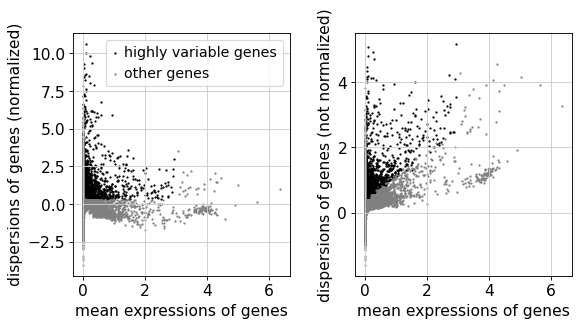

In [80]:
sc.pl.highly_variable_genes(adata)

In [81]:
print(np.sum(adata.var.highly_variable))

2623


In [82]:
adata = adata[:, adata.var.highly_variable].copy()

In [83]:
adata.write('./write/GSE172511_lognorm_hvg.h5ad')

# Preliminary processing

In [84]:
adata = sc.read('./write/GSE172511_lognorm_hvg.h5ad')

In [85]:
# normally regress out the top layers of unwanted effects
sc.pp.regress_out(adata, ['total_counts','n_genes_by_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:01)


In [86]:
# scale for pca
sc.pp.scale(adata)
# pca
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


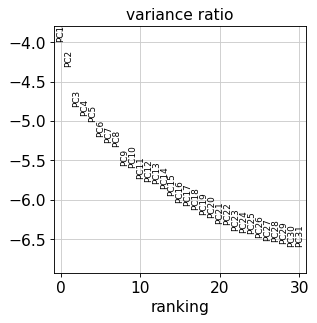

In [87]:
sc.pl.pca_variance_ratio(adata, log=True)

In [88]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


In [89]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


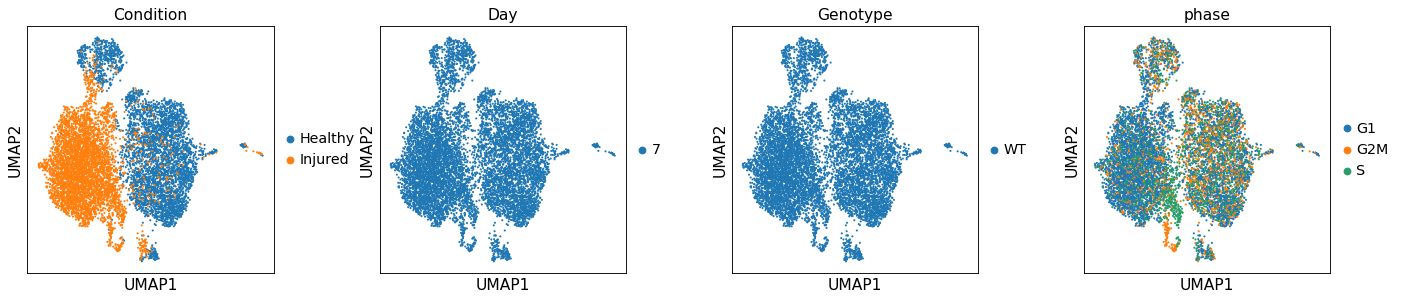

In [90]:
sc.pl.umap(adata, color= ['Condition', 'Day', 'Genotype', 'phase'], wspace=0.3)

In [91]:
adata.write('./write/GSE172511_processed.h5ad')